# 03. Training and evaluation of classification models

In [1]:
import pandas as pd
import numpy as np
import os
import joblib # для сохранения модели

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## 1. Loading processed data

In [2]:
processed_data_path = os.path.join('..', 'processed_data', 'inquiries_processed.csv')

try:
    df = pd.read_csv(processed_data_path)
    print(f"Processed dataset successfully loaded from {processed_data_path}")
    print(f"Dataset size: {df.shape}")
except FileNotFoundError:
    print(f"Error {processed_data_path}")
    df = pd.DataFrame()

# Проверим наличие пропусков в 'processed_text', которые могли появиться, если текст состоял только из стоп-слов
df.dropna(subset=['processed_text'], inplace=True)
print(f"Size of dataset after deleting empty lines: {df.shape}")

df.head()

Processed dataset successfully loaded from ..\processed_data\inquiries_processed.csv
Dataset size: (98, 4)
Size of dataset after deleting empty lines: (98, 4)


,text,category,tokens,processed_text
0,"Здравствуйте, как я могу получить адресную спр...",Запрос на госуслугу,"['здравствовать', 'мочь', 'получить', 'адресны...",здравствовать мочь получить адресный справка о...
1,Почему портал электронного правительства посто...,Техническая проблема,"['почему', 'портал', 'электронный', 'правитель...",почему портал электронный правительство постоя...
2,Выражаю благодарность сотруднику ЦОНа №3 город...,Предложение/Отзыв,"['выражать', 'благодарность', 'сотрудник', 'цо...",выражать благодарность сотрудник цон город аст...
3,Не могу записаться на прием в поликлинику чере...,Техническая проблема,"['мочь', 'записаться', 'прием', 'поликлиника',...",мочь записаться прием поликлиника мобильный пр...
4,Какие документы необходимы для регистрации рож...,Запрос на госуслугу,"['какой', 'документ', 'необходимый', 'регистра...",какой документ необходимый регистрация рождени...


## 2. Preparation of data for modelling

In [4]:
X = df['processed_text']
y = df['category']

# Инициализация TF-IDF векторизатора
vectorizer = TfidfVectorizer(max_features=5000)

X_tfidf = vectorizer.fit_transform(X)

print(f"Text data converted to TF-IDF matrix size: {X_tfidf.shape}")

Text data converted to TF-IDF matrix size: (98, 462)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    y, 
    test_size=0.2, 
    random_state=42, # для воспроизводимости результатов
    stratify=y
)

print(f"Размер training sample: {X_train.shape[0]} строк")
print(f"Размер test sample: {X_test.shape[0]} строк")

Размер training sample: 78 строк
Размер test sample: 20 строк


## 3. Model learning and evaluation

In [6]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42)
}

results = {}

for model_name, model in models.items():
    print(f"--- Model training: {model_name} ---")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification report:")
    print(report)
    print("\n")

--- Model training: Multinomial Naive Bayes ---
Accuracy: 0.6000
Classification report:
                      precision    recall  f1-score   support

              Жалоба       0.50      0.25      0.33         4
 Запрос на госуслугу       0.67      1.00      0.80         4
 Консультация/Вопрос       1.00      0.50      0.67         4
   Предложение/Отзыв       0.50      0.25      0.33         4
Техническая проблема       0.50      1.00      0.67         4

            accuracy                           0.60        20
           macro avg       0.63      0.60      0.56        20
        weighted avg       0.63      0.60      0.56        20



--- Model training: Logistic Regression ---
Accuracy: 0.6500
Classification report:
                      precision    recall  f1-score   support

              Жалоба       0.50      0.25      0.33         4
 Запрос на госуслугу       0.67      1.00      0.80         4
 Консультация/Вопрос       1.00      0.50      0.67         4
   Предложение/О

## 4. Result visualization (Confusion Matrix)

In [8]:
best_model_name = "Logistic Regression"
best_model_predictions = results[best_model_name]['predictions']

class_names = sorted(y.unique())

cm = confusion_matrix(y_test, best_model_predictions, labels=class_names)

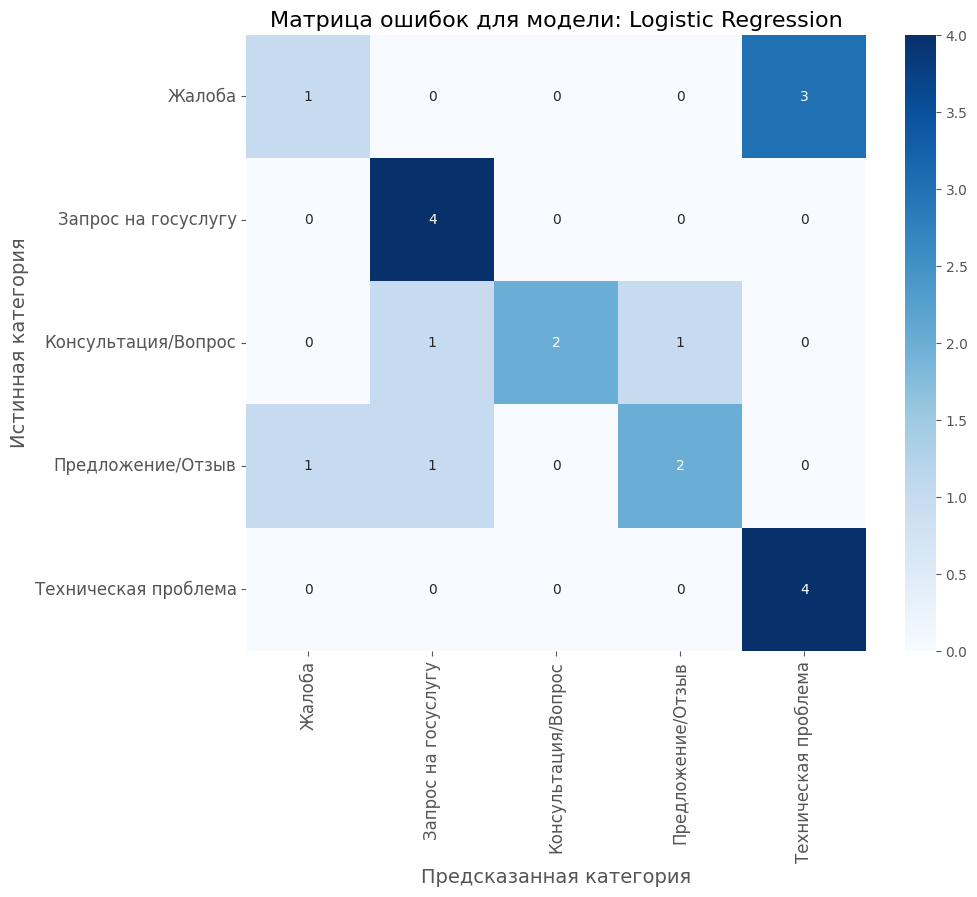

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица ошибок для модели: {best_model_name}', fontsize=16)
plt.xlabel('Предсказанная категория', fontsize=14)
plt.ylabel('Истинная категория', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 5. Saving the best model and vector

In [10]:
best_model = models['Logistic Regression'] 

models_dir = os.path.join('..', 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Создана директория: {models_dir}")

model_path = os.path.join(models_dir, 'best_classifier_model.joblib')
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.joblib')


Создана директория: ..\models


In [11]:
joblib.dump(best_model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print(f"\nЛучшая модель сохранена в: {model_path}")
print(f"Векторизатор сохранен в: {vectorizer_path}")


Лучшая модель сохранена в: ..\models\best_classifier_model.joblib
Векторизатор сохранен в: ..\models\tfidf_vectorizer.joblib
